#  import kit

In [ ]:
import math, cmath
import numpy as np
import importlib
import PEC_Readout_Module as pecro
import PEC_TQG_Module_FID_V2 as peccx
import Restore_Retrieve as RR

import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import *
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2

In [3]:
importlib.reload(peccx)
importlib.reload(RR)

<module 'Restore_Retrieve' from '/home/xiaonan/PEC/Restore_Retrieve.py'>

In [4]:
token = "PJubuPXreZKAxan0yV6OLEIkdKipFYGgvvkGQSZAtpMU"
instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/f071734952cb4c9993a642d0a87d18bb:392306ae-fe55-475c-a8c5-978d0ba1871e::'
device_name = "kingston"
device = "ibm_" + device_name
device, noise_model, service = pec.load_ibm_backend(token, instance, device)

In [5]:
backend = AerSimulator.from_backend(device)
backend_options = {
    "noise_model": noise_model,
    "basis_gates": noise_model.basis_gates,
    "coupling_map": device.configuration().coupling_map,
    # parallelism knobs
    "max_parallel_threads": 0,
    "max_parallel_experiments": 8,
    "max_parallel_shots": 0,
    "max_memory_mb": 20000
    # "device": "GPU",  # if you have qiskit-aer-gpu
}
run_options = {
    "shots": 1024,
    # "seed_simulator": 12345,
}

estimator = EstimatorV2(
    options={
        "backend_options": backend_options,
        "run_options": run_options,
        # "default_precision": 0.0,  # if you want deterministic path where applicable
    }
)

backendqubitNum = backend.num_qubits
print(backendqubitNum)


156


# Fixed parameters

In [ ]:
Bell_circuit = QuantumCircuit(qreg, creg)
Bell_circuit.h(0)
Bell_circuit.cx(0, 1)
Bell_circuit.draw('mpl')

3

# Calculate Readout PEC Observable

In [ ]:
device_qubits = backendqubitNum
qubit_numbers = 4
initial_circuits_v = pec.build_initial_states()
measurements = pec.build_measurement_pauli(v, observable_number=backendqubitNum)
# job = pec.run_measurements(initial_circuits_v, measurements, backend, shots=1000)
# g_matrix = pec.collect_results(job, qubit_numbers)
# A_matrix = pec.get_preparation_matrix(qubit_numbers)
# B_matrix, noisy_coefficient = pec.build_corrected_observables(g_matrix, A_matrix, qubit_numbers)
# ideal_measurements = pec.build_ideal_measurement(noisy_coefficient, v, qubit_numbers, device_qubits)
# ideal_measurements

In [ ]:
B_matrix

array([[ 1.    ,  0.    ,  0.    ,  0.    ],
       [-0.0129,  1.0013,  0.0097,  0.0015],
       [ 0.0055, -0.0041,  0.9737, -0.0053],
       [-0.0019,  0.0097, -0.0017,  0.9871]])

# parameters

In [26]:
def normalize(h): 
    a = h / np.sqrt(np.sum(h**2))
    return a

def A_z(h):
    n = 0.0198763
    d = (np.sqrt(np.sum(h**2)))**3
    a_x = (n/d)*(-3)*normalize(h)[2]*normalize(h)[0]
    a_y = (n/d)*(-3)*normalize(h)[2]*normalize(h)[1]
    a_z = (n/d)*(1-3*normalize(h)[2]**2)

    return np.array([a_x, a_y, a_z])

R_z = np.zeros([len(BZ),len(tlist)]) 
theta = np.zeros([len(BZ),len(R),len(R[0]),len(tlist)])
phi = np.zeros([len(BZ),len(R),len(R[0]),len(tlist)])
Lambda = np.zeros([len(BZ),len(R),len(R[0]),len(tlist)])
gamma = np.zeros([len(BZ),len(R),len(R[0]),len(tlist)])

for r in range(len(R)):
    for bz in range(len(BZ)):
        omega_0 = (0,0,Gamma_C13*BZ[bz])
        for i in range(len(tlist)):         
            for p in range(len(R[r])):
                omega_1 = np.array([A_z(R[r][p])[0],A_z(R[r][p])[1],A_z(R[r][p])[2]+Gamma_C13*BZ[bz]])
                
                normalized_omega1 = normalize(omega_1)

                R_z[bz][i] = 2*np.pi*omega_0[2]*(itv*i+ti)

                theta[bz][r][p][i] = (2*math.asin(math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2) *np.sqrt(normalized_omega1[0]**2 + normalized_omega1[1]**2)))

                phi[bz][r][p][i] = ((-np.pi)/2
                +cmath.polar(complex(normalized_omega1[0],normalized_omega1[1]))[1]
                - cmath.polar(
                    complex(
                        math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                        -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])

                Lambda[bz][r][p][i] = ((np.pi)/2
                -cmath.polar(complex(normalized_omega1[0],normalized_omega1[1]))[1]
                - 2*np.pi*Gamma_C13*BZ[bz]*(itv*i+ti)
                - cmath.polar(
                    complex(
                        math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                        -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])

                gamma[bz][r][p][i] =((2*np.pi*Gamma_C13*BZ[bz]*(itv*i+ti))/2
                +cmath.polar(complex(
                        math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                        -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])


In [27]:
#根據v,c,a的位置設定qubit的位元
qreg = QuantumRegister(bits_len, 'q')
creg = ClassicalRegister(bits_len, 'c')

# wrapping circuit as {"bz0": [[carbon set], [carbon set], ... , [carbon set]], "bz1":[time list], ..., "bzn":[time list]}
qc_bzls = {}
for bz in range(len(BZ)): 
    qc_tmls = []    
    for i in range (len(tlist)):
        qc_cbls = []
        for r in range (len(R)): 
            #IBM空白的電路圖
            circuit = QuantumCircuit(qreg, creg)

            #State preparation & polarization
            circuit.h(v)
            for j in range (len(R[r])):
                circuit.h(c[j])
                circuit.cx(c[j], a[j])
                # circuit.u((np.pi)/2, 0, 0, c[j])

            #FID
            for j in range (len(R[r])):
                circuit.rz(R_z[bz][i], c[j])
                #C
                circuit.p(gamma[bz][r][j][i] + (phi[bz][r][j][i] + Lambda[bz][r][j][i])/2, v)
                circuit.p((Lambda[bz][r][j][i] - phi[bz][r][j][i])/2, c[j])
                #CX
                circuit.cx(v, c[j])
                #B
                circuit.u(-theta[bz][r][j][i]/2, 0, (phi[bz][r][j][i] + Lambda[bz][r][j][i])/2, c[j])
                #CX
                circuit.cx(v, c[j])
                #A
                circuit.u(theta[bz][r][j][i]/2, phi[bz][r][j][i], 0, c[j])

            qc_cbls.append(circuit)
        qc_tmls.append(qc_cbls)
    qc_bzls.update({f'{BZ[bz]}':qc_tmls})

In [28]:
qc_bzls['50']

[[<qiskit.circuit.quantumcircuit.QuantumCircuit at 0x73bb809af8e0>]]

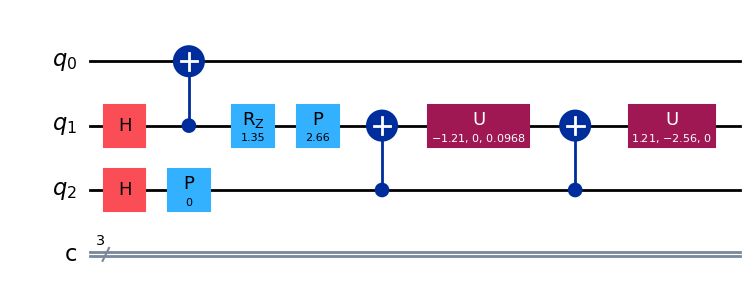

In [13]:
display(qc_bzls['100'][2][0].draw(output='mpl'))

# Calculate CNOT PEC Weight

In [14]:
estimator = Estimator(mode=backend)
estimator.options.default_shots = 1024

In [ ]:
grammatrix = peccx.compute_tqg_matrices(estimator, qc_bzls['0'][0][0], obs_batch=64)

# 取矩陣
for key, M in result["matrices"].items():
    print("CNOT", key, "matrix shape:", M.shape)
# row / col 對應哪些標籤
row_labels = result["row_labels"]   # observables（列）
col_labels = result["col_labels"]   # initial（行）

(c1,t0) 1/64
(c1,t0) 2/64
(c1,t0) 3/64
(c1,t0) 4/64
(c1,t0) 5/64
(c1,t0) 6/64
(c1,t0) 7/64
(c1,t0) 8/64
(c1,t0) 9/64
(c1,t0) 10/64
(c1,t0) 11/64
(c1,t0) 12/64
(c1,t0) 13/64
(c1,t0) 14/64
(c1,t0) 15/64
(c1,t0) 16/64
(c1,t0) 17/64
(c1,t0) 18/64
(c1,t0) 19/64
(c1,t0) 20/64
(c1,t0) 21/64
(c1,t0) 22/64
(c1,t0) 23/64
(c1,t0) 24/64
(c1,t0) 25/64
(c1,t0) 26/64
(c1,t0) 27/64
(c1,t0) 28/64
(c1,t0) 29/64
(c1,t0) 30/64
(c1,t0) 31/64
(c1,t0) 32/64
(c1,t0) 33/64
(c1,t0) 34/64
(c1,t0) 35/64
(c1,t0) 36/64
(c1,t0) 37/64
(c1,t0) 38/64
(c1,t0) 39/64
(c1,t0) 40/64
(c1,t0) 41/64
(c1,t0) 42/64
(c1,t0) 43/64
(c1,t0) 44/64
(c1,t0) 45/64
(c1,t0) 46/64
(c1,t0) 47/64
(c1,t0) 48/64
(c1,t0) 49/64
(c1,t0) 50/64
(c1,t0) 51/64
(c1,t0) 52/64
(c1,t0) 53/64
(c1,t0) 54/64
(c1,t0) 55/64
(c1,t0) 56/64
(c1,t0) 57/64
(c1,t0) 58/64
(c1,t0) 59/64
(c1,t0) 60/64
(c1,t0) 61/64
(c1,t0) 62/64
(c1,t0) 63/64
(c1,t0) 64/64
(c2,t1) 1/64
(c2,t1) 2/64
(c2,t1) 3/64
(c2,t1) 4/64
(c2,t1) 5/64
(c2,t1) 6/64
(c2,t1) 7/64
(c2,t1) 8/64
(c2,t1) 9

In [52]:
manifest = RR.save_result(grammatrix, fname="grammatrix", parent_dir="TQGGramMatrix")

In [19]:
grammatrix = RR.load_matrix("TQGGramMatrix/20250902-174159/grammatrix.npy")  
print("num_qubits:", grammatrix["num_qubits"])
print("D x D:", len(grammatrix["row_labels"]), "x", len(grammatrix["col_labels"]))
print("matrices keys:", list(grammatrix["matrices"].keys()))

num_qubits: 3
D x D: 64 x 64
matrices keys: [(1, 0), (2, 1)]


In [20]:
# avgPT = peccx.transform_tqg_matrices_cxm_Ainv(result, cxm_sparse=True, ainv_sparse=False)
avgPT1 = peccx.transform_tqg_matrices_cxm_Ainv(grammatrix, cxm_sparse=True, ainv_sparse=False)
for k, Mprime in avgPT1["matrices"].items():
    print("CNOT", k, "->", Mprime.shape)
avgPT1

CNOT (1, 0) -> (64, 64)
CNOT (2, 1) -> (64, 64)


{'num_qubits': 3,
 'row_labels': ['III',
  'IIX',
  'IIY',
  'IIZ',
  'IXI',
  'IXX',
  'IXY',
  'IXZ',
  'IYI',
  'IYX',
  'IYY',
  'IYZ',
  'IZI',
  'IZX',
  'IZY',
  'IZZ',
  'XII',
  'XIX',
  'XIY',
  'XIZ',
  'XXI',
  'XXX',
  'XXY',
  'XXZ',
  'XYI',
  'XYX',
  'XYY',
  'XYZ',
  'XZI',
  'XZX',
  'XZY',
  'XZZ',
  'YII',
  'YIX',
  'YIY',
  'YIZ',
  'YXI',
  'YXX',
  'YXY',
  'YXZ',
  'YYI',
  'YYX',
  'YYY',
  'YYZ',
  'YZI',
  'YZX',
  'YZY',
  'YZZ',
  'ZII',
  'ZIX',
  'ZIY',
  'ZIZ',
  'ZXI',
  'ZXX',
  'ZXY',
  'ZXZ',
  'ZYI',
  'ZYX',
  'ZYY',
  'ZYZ',
  'ZZI',
  'ZZX',
  'ZZY',
  'ZZZ'],
 'col_labels': ['000',
  '001',
  '00+',
  '00R',
  '010',
  '011',
  '01+',
  '01R',
  '0+0',
  '0+1',
  '0++',
  '0+R',
  '0R0',
  '0R1',
  '0R+',
  '0RR',
  '100',
  '101',
  '10+',
  '10R',
  '110',
  '111',
  '11+',
  '11R',
  '1+0',
  '1+1',
  '1++',
  '1+R',
  '1R0',
  '1R1',
  '1R+',
  '1RR',
  '+00',
  '+01',
  '+0+',
  '+0R',
  '+10',
  '+11',
  '+1+',
  '+1R',
  '++0',
  '++1',

In [21]:
weights = peccx.compute_inv_weights_for_package(avgPT1)
manifest = RR.save_vectors(weights, fname="weight", parent_dir="TQGWeight")
weights

{(1,
  0): array([ 8.101307458021951e-01, -2.556010219535665e-03,
        -2.716281179829860e-03, -2.822053771148858e-03,
        -6.117754493146499e-04, -1.816380302555737e-05,
         3.087619748138454e-05,  9.026441553630915e-04,
         3.036123541734666e-04,  5.626381112323539e-05,
        -1.519409209304427e-04, -1.243146974205540e-03,
         2.746152861218888e-01, -1.167313867478662e-03,
        -1.941191572049666e-03, -1.081233735431245e-03,
         2.574097998886374e-01, -8.702764556612758e-04,
        -1.166602336241218e-03, -8.265970193530453e-04,
        -5.006264943337210e-03, -3.883620334664065e-04,
         5.296254842953665e-04,  2.408849985514189e-04,
        -4.654461994241164e-03, -4.905956932689491e-04,
        -1.553454906161496e-04, -4.482117270748313e-04,
        -2.790442681705394e-01,  1.629050826687031e-03,
         1.209126654179132e-03,  1.030484396759138e-03,
         2.040886913203879e-04, -2.203666994698567e-04,
         1.587341927726665e-04, -1.296

In [32]:
importlib.reload(peccx)
importlib.reload(RR)

<module 'Restore_Retrieve' from '/home/xiaonan/PEC/Restore_Retrieve.py'>

In [8]:
loadweights = RR.load_vectors("TQGWeight/20250908-135302/weight.npy")
loadweights

{'vector_dim': 64,
 'keys': [(1, 0), (2, 1)],
 'vectors': {(1,
   0): array([ 8.101307458021951e-01, -2.556010219535665e-03,
         -2.716281179829860e-03, -2.822053771148858e-03,
         -6.117754493146499e-04, -1.816380302555737e-05,
          3.087619748138454e-05,  9.026441553630915e-04,
          3.036123541734666e-04,  5.626381112323539e-05,
         -1.519409209304427e-04, -1.243146974205540e-03,
          2.746152861218888e-01, -1.167313867478662e-03,
         -1.941191572049666e-03, -1.081233735431245e-03,
          2.574097998886374e-01, -8.702764556612758e-04,
         -1.166602336241218e-03, -8.265970193530453e-04,
         -5.006264943337210e-03, -3.883620334664065e-04,
          5.296254842953665e-04,  2.408849985514189e-04,
         -4.654461994241164e-03, -4.905956932689491e-04,
         -1.553454906161496e-04, -4.482117270748313e-04,
         -2.790442681705394e-01,  1.629050826687031e-03,
          1.209126654179132e-03,  1.030484396759138e-03,
          2.04088691

In [1]:
# 3) observables：兩個觀測量（你自己給）
MX = SparsePauliOp(['I' + 'X' + 'I'])
MY = SparsePauliOp(['I' + 'Y' + 'I'])
observables = {
    "measX": MX,            # SparsePauliOp
    "measY": MY,
}

# 4) 跑整包（可續跑、顯示進度）
results = peccx.run_tqg_pec_package(
    estimator=estimator,
    qc_bzls=qc_bzls,
    observables=observables,
    weights_map=loadweights["vectors"],
    combo_batch_size=256,        # 建議 main code 把 batch 調大，減少呼叫次數
    ckpt_path="tqg_pec_run_v3.jsonl",
    resume=True,
    t_backend=backend,               # transpile 用同一個 backend，雜訊/耦合一致
    t_opt_level=0,               # 2 或 3 會比 0 更快（layout & 合併 gate）
    verbose=True
)

# results 是扁平 dict：key= "Bz|tX|cY|iZ|obs"
# 每行也都在 tqg_pec_run.jsonl 裡，隨時能中斷再續跑


NameError: name 'SparsePauliOp' is not defined

In [25]:
shots = 1024
estimator = Estimator(mode=backend)

jobX_N = {}
jobY_N = {}
jobX_M = {}
jobY_M = {}
for Bz, circuit_tmls in qc_bzls.items():
    batchedX_N = []
    batchedY_N = []
    batchedX_M = []
    batchedY_M = []
    for circuit_cbls in circuit_tmls:
        for cir in circuit_cbls:
            CirTran = q.compiler.transpile(cir, backend=backend, optimization_level=0)
            batchedX_N.append((CirTran, measurements['measX']))
            batchedY_N.append((CirTran, measurements['measY']))
            batchedX_M.append((CirTran, ideal_measurements['measX']))
            batchedY_M.append((CirTran, ideal_measurements['measY']))
    jobX_N.update({Bz:estimator.run(batchedX_N)})
    jobY_N.update({Bz:estimator.run(batchedY_N)})
    jobX_M.update({Bz:estimator.run(batchedX_M)})
    jobY_M.update({Bz:estimator.run(batchedY_M)})
    

KeyboardInterrupt: 

In [ ]:
def get_expectation(job):
    expectation = {}
    for Bz, jb in job.items():
        result = jb.result()
        expct = [res.data.evs for res in result]
        expectation.update({Bz:expct})
    return expectation   

expctX_N = get_expectation(jobX_N)
expctY_N = get_expectation(jobY_N)
expctX_M = get_expectation(jobX_M)
expctY_M = get_expectation(jobY_M)

In [ ]:
print(expctX_N)
print(expctX_M)

In [ ]:
BZstr = [str(n) for n in BZ]

def noisy_phi_total(real, imag):
    phi_total = {}
    for bz in BZstr:        
        phi = np.array(real[bz]) + np.array(imag[bz])*(1j)
        phi = phi.reshape(len(tlist), len(R))
        phi_total[bz] = [np.prod(data) for data in phi]
    return phi_total

def output_format(Sum, time=[], file=None):
    for t, e in zip(time, Sum):
        line = f"{{{t}, {e}}},\n"
        print(line, end="")
        if file:
            file.write(line)

def python_sci_to_mathematica_str(sci_input):
    if isinstance(sci_input, float):
        sci_str = f"{sci_input:.15e}"
    else:
        sci_str = str(sci_input)
    
    if "e" in sci_str or "E" in sci_str:
        base, exponent = sci_str.lower().split("e")
        return f"{base}*^{int(exponent)}"
    else:
        return sci_str  

def output(phitotal, time=[], path=None):
    default_path = "output.txt"
    file_path = path if path else default_path
    with open(file_path, "w", encoding="utf-8") as f:
        for bz in BZstr:
            f.write(f"Bz: {bz}\n")
            print(f"Bz: {bz}")

            re = [python_sci_to_mathematica_str(r.real) for r in phitotal[bz]]
            im = [python_sci_to_mathematica_str(i.imag) for i in phitotal[bz]]

            f.write("Real part:\n")
            output_format(re, time, file=f)
            f.write("Imag part:\n")
            output_format(im, time, file=f)
            f.write("\n")

In [ ]:
Noisy_phitotal = noisy_phi_total(expctX_N, expctY_N)
Mitigated_phitotal = noisy_phi_total(expctX_M, expctY_M)
# Mitigated_phitotal

In [ ]:
Noisypath = f"processed data/0821_noisy_Sim{device_name}_v={v}_{len(Rvector)}C.txt"
Mitigatedpath = f"processed data/mitigated_Sim{device_name}_v={v}_{len(Rvector)}C.txt"
output(Noisy_phitotal, tlist, path = Noisypath)
output(Mitigated_phitotal, tlist, path = Mitigatedpath)

In [ ]:
print(Noisy_phitotal)